In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create datasets

In [112]:
# DON'T RUN THIS NOTEBOOK if you don't have data.csv
# download it here: https://www.kaggle.com/edumucelli/spotifys-worldwide-daily-song-ranking
# and unzip it in the data folder
# data.csv file doesn't exist in github because it exeeds github's size limit

In [127]:
rankings=pd.read_csv("./data/data.csv")

In [128]:
# show regions
rankings['Region'].unique()

array(['ec', 'fr', 'ar', 'fi', 'no', 'it', 'lt', 'ph', 'tw', 'nz', 'ee',
       'tr', 'us', 'sv', 'cr', 'de', 'cl', 'jp', 'br', 'hn', 'gt', 'ch',
       'hu', 'ca', 'pe', 'be', 'my', 'dk', 'bo', 'pl', 'at', 'pt', 'se',
       'mx', 'pa', 'uy', 'is', 'es', 'cz', 'ie', 'nl', 'sk', 'co', 'sg',
       'id', 'do', 'lu', 'gb', 'global', 'py', 'au', 'lv', 'gr', 'hk'],
      dtype=object)

#### Request audio features from Spotify API 
The audio feature dataset only covers 30-40 percent of the songs in the top 100 ranking, so we need to get audio features ourselves. 

In [165]:
# Spotify API authorization
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id, client_key)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [169]:
# request auido features from song name
def get_audio_features(name):
    # search for song ID from song name
    search_result = spotify.search(q='track:' + name , type='track',market='gb')
    
    # if no result found, return dataframe with NAN
    if len(search_result['tracks']['items'])==0:
        raw = pd.DataFrame(np.nan, index=[0], columns=['name','acousticness','danceability','duration_ms',
                          'energy','instrumentalness','key','liveness', 
                          'loudness','mode','speechiness','tempo',
                          'time_signature','valence'])
    else:
        trackID=search_result['tracks']['items'][0]['id']
        # request audio features 
        raw = pd.DataFrame(spotify.audio_features(tracks=trackID))
    raw['name'] = name
    audio_features = raw[['name','acousticness','danceability','duration_ms',
                          'energy','instrumentalness','key','liveness', 
                          'loudness','mode','speechiness','tempo',
                          'time_signature','valence']]
    return audio_features
# example
get_audio_features('shape of you')

,name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,shape of you,0.581,0.825,233713,0.652,0,1,0.0931,-3.183,0,0.0802,95.977,4,0.931


In [167]:
# extract yearly rankings for a region, and add in the audio features
def region_ranking(country_name,country_code):
    # data from region
    region = rankings.loc[rankings['Region']==country_code]
    
    # yearly aggregated top 100 songs in the region
    region_rankings = region.groupby('Track Name',as_index=False).sum() \
                .sort_values('Streams',ascending=False).reset_index(drop=True)[['Track Name','Streams']][:100]
    region_rankings.columns = ['name','streams']
    
    # dataframe of audio features
    for n,song in enumerate(region_rankings['name']):
        if n==0:
            audio_features = get_audio_features(song)
        else:
            next_song_features = get_audio_features(song)
            audio_features = pd.concat([audio_features,next_song_features])
    audio_features = audio_features.reset_index(drop=True)
    
    # combine ranking and audio features
    result = pd.merge(region_rankings,audio_features,on='name',how='left')
    
    # save to csv file
    result.to_csv("./data/{}_complete.csv".format(country_name))
    return result

In [ ]:
global_data = region_ranking('global','global')
finland_data = region_ranking('finland','fi')
sweden_data = region_ranking('sweden','se')

In [125]:
global_data[:5]

,name,streams,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Shape of You,1490812208,0.5810,0.825,233713,0.652,0.000000,1,0.0931,-3.183,0,0.0802,95.977,4,0.931
1,Despacito - Remix,919199404,0.2280,0.653,228827,0.816,0.000000,2,0.0967,-4.353,1,0.1670,178.086,4,0.816
2,Despacito (Featuring Daddy Yankee),742841612,0.2080,0.659,228200,0.802,0.000000,2,0.1230,-4.790,1,0.1480,177.936,4,0.863
3,Something Just Like This,692404365,0.0498,0.617,247160,0.635,0.000014,11,0.1640,-6.769,0,0.0317,103.019,4,0.446
4,Unforgettable,678399824,0.0293,0.726,233902,0.769,0.010100,6,0.1040,-5.043,1,0.1230,97.985,4,0.733


## Checking data quality

In [174]:
# missing values
print(pd.isna(global_data).sum())
print('*****'*15)
print(pd.isna(finland_data).sum())
print('*****'*15)
print(pd.isna(sweden_data).sum())

name                0
streams             0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64
***************************************************************************
name                0
streams             0
acousticness        4
danceability        4
duration_ms         4
energy              4
instrumentalness    4
key                 4
liveness            4
loudness            4
mode                4
speechiness         4
tempo               4
time_signature      4
valence             4
dtype: int64
***************************************************************************
name                0
streams             0
acousticness        2
danceability        2
duration_ms         2
energy              2
instrumentalness    2
key     

In [176]:
# for ranking data, missing value is caused by the song being removed from spotify
na_rows = rankings[rankings.isnull().any(axis=1)]
na_rows['URL'][:5]

39428    https://open.spotify.com/track/3RXkboS74UYzN14...
39456    https://open.spotify.com/track/4JAyIDXOqNM6qHu...
39463    https://open.spotify.com/track/3bVbQvGVIe4n24A...
39490    https://open.spotify.com/track/3eFJqPe8VUYrABb...
39631    https://open.spotify.com/track/3RXkboS74UYzN14...
Name: URL, dtype: object

In [178]:
# remove rows with missing data
finland_data.dropna(axis=0,how='any',inplace=True)
sweden_data.dropna(axis=0,how='any',inplace=True)

In [188]:
# now there are 0 missing values
print(global_data.shape)
print('*****'*5)
print(finland_data.shape)
print('*****'*5)
print(sweden_data.shape)

(100, 15)
*************************
(96, 15)
*************************
(98, 15)


## Exploratory Data Analysis

Text(0.5, 1.05, 'Total yearly number of streams per region')

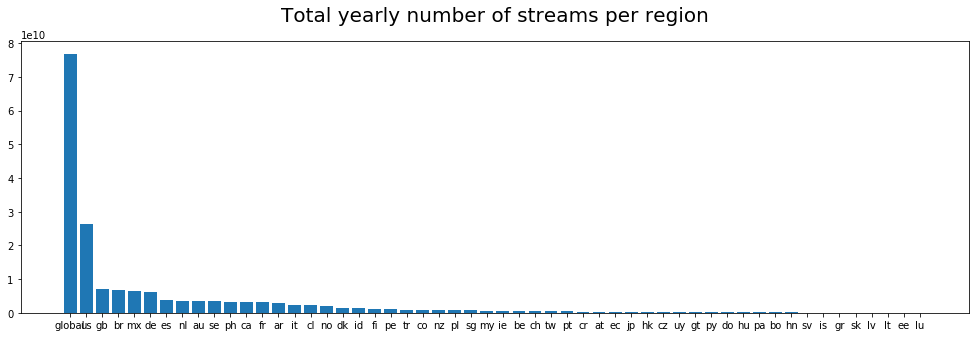

In [181]:
# regional streaming count
streams = rankings['Streams'].groupby(rankings['Region']).sum()
streams_per_region = pd.DataFrame({'Region':streams.index, 'Streams':streams.values}).sort_values('Streams',ascending=False)
plt.figure(figsize=(17,5))
plt.bar(streams_per_region['Region'],streams_per_region['Streams'])
plt.title('Total yearly number of streams per region',size=20,y=1.05)

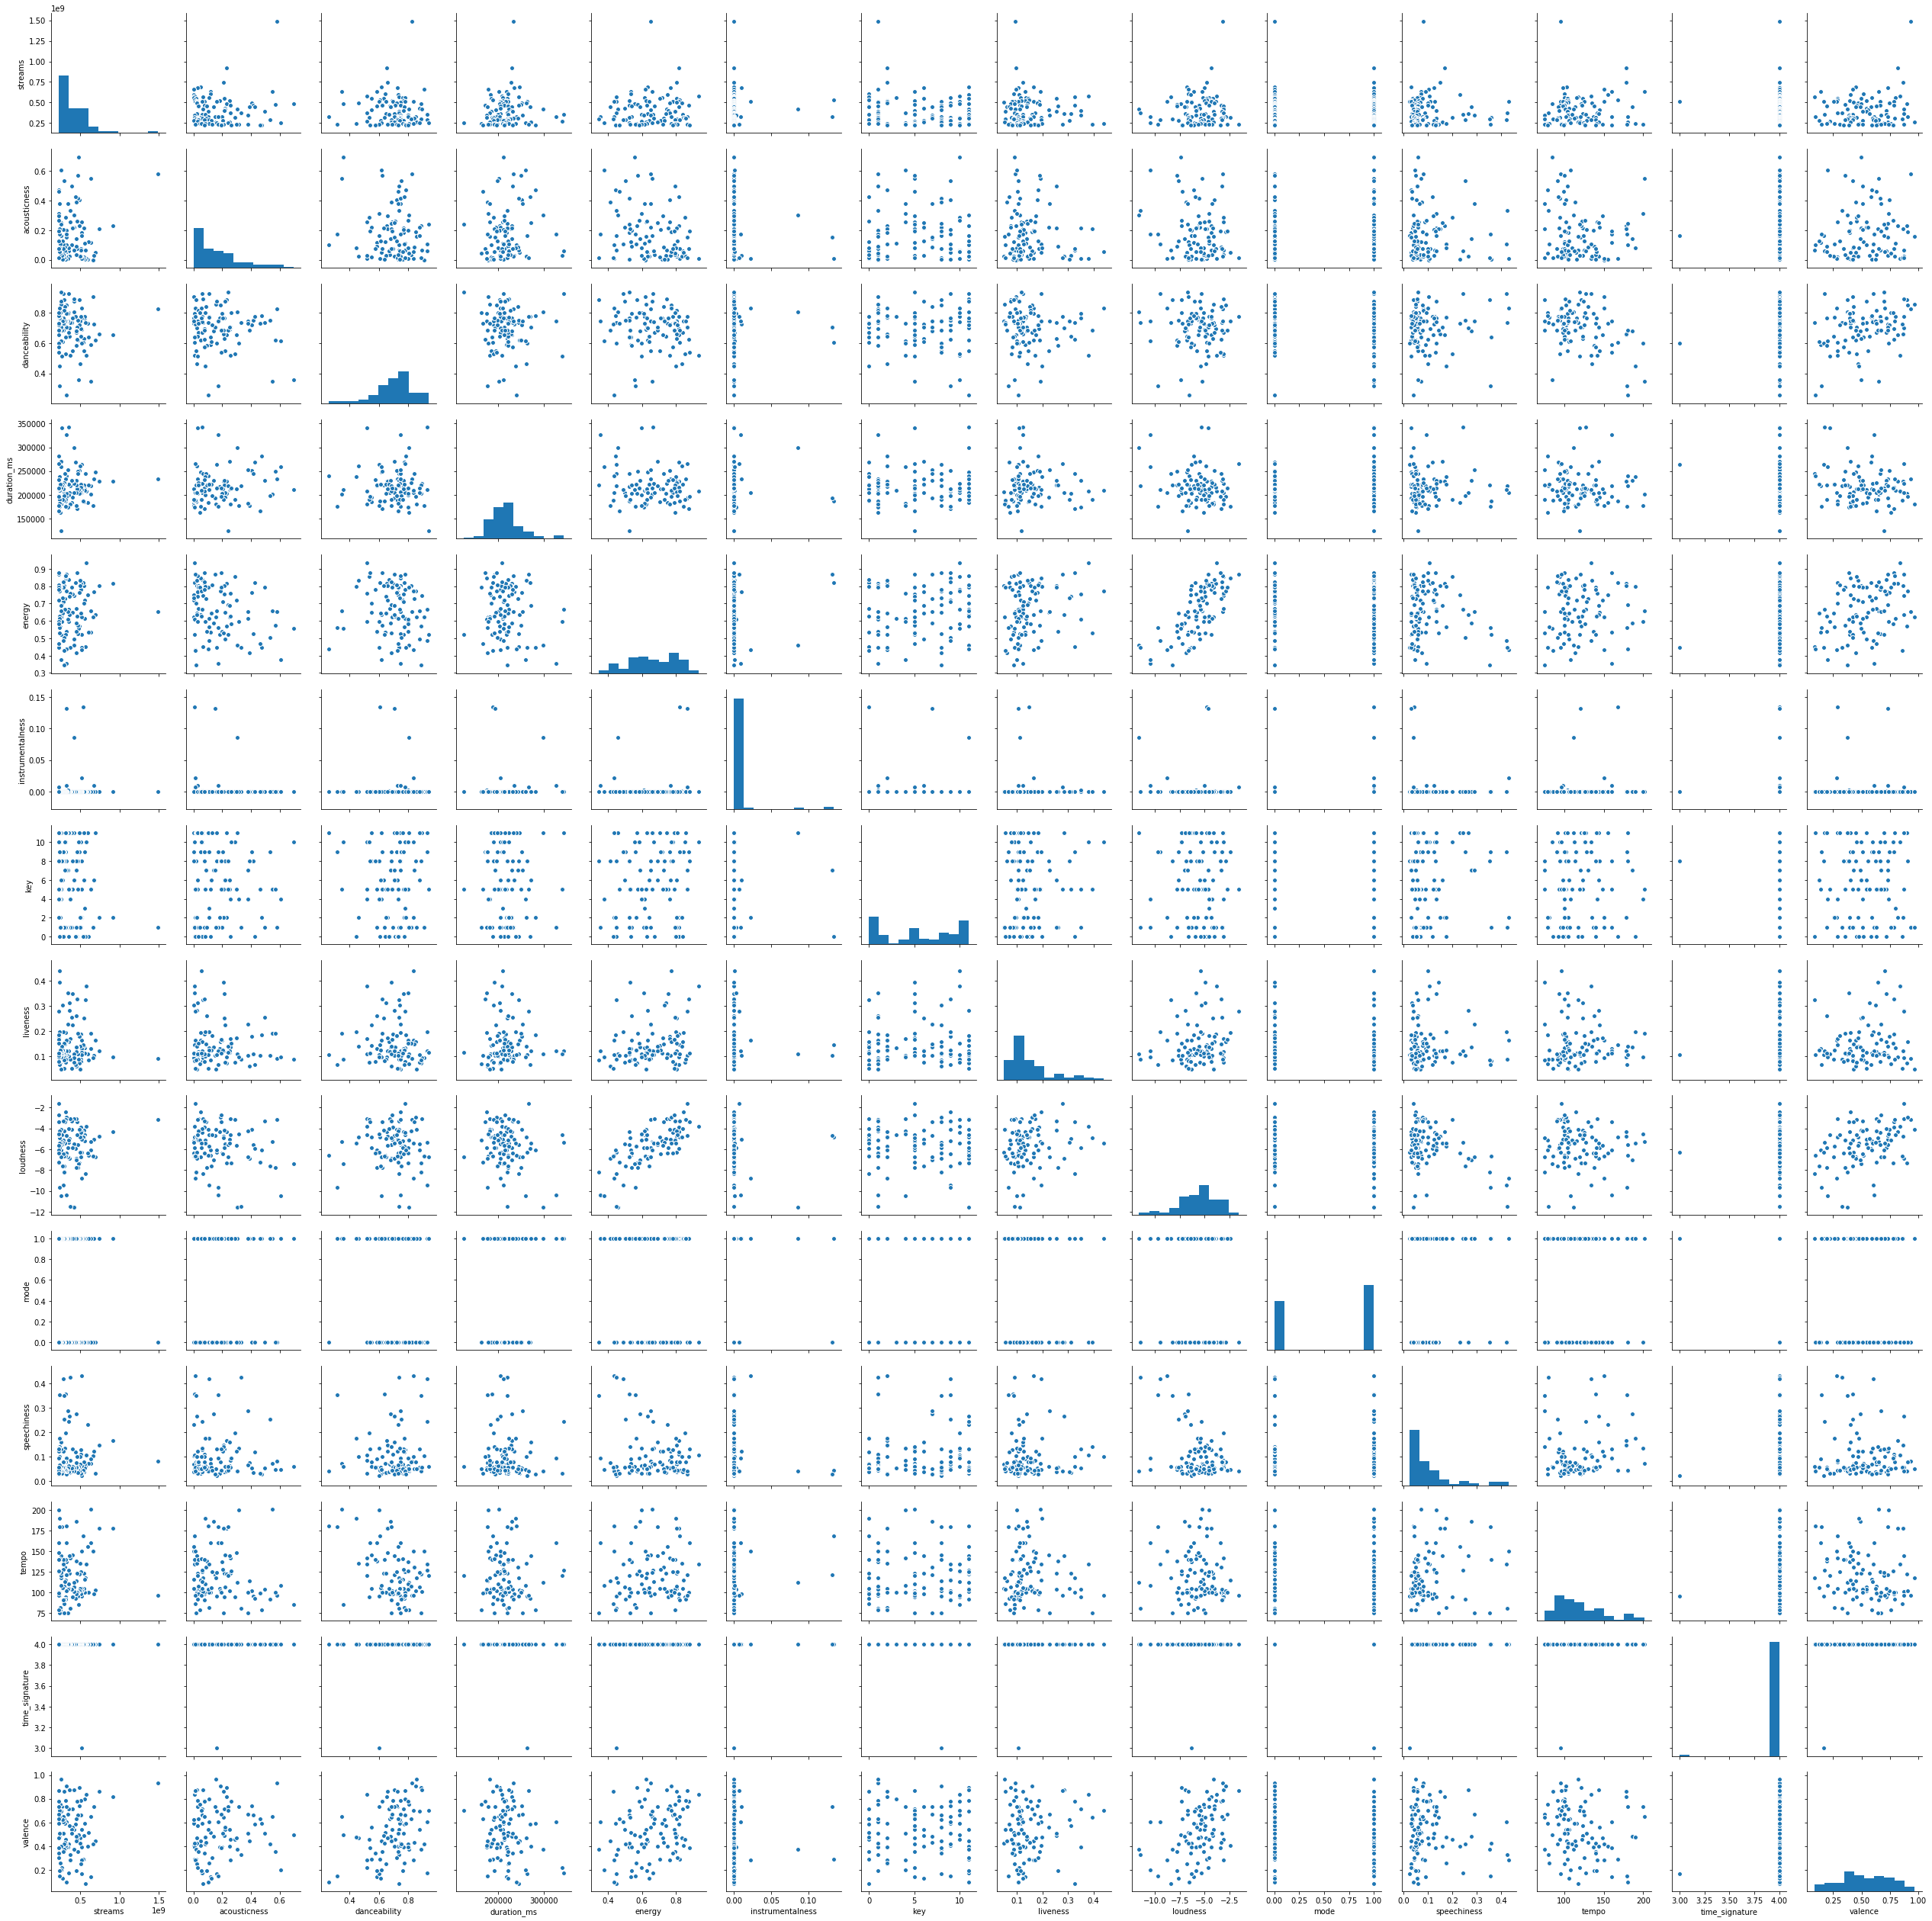

In [183]:
# Feature data
# feature with low variability will not be used as they contain little information
sns.pairplot(global_data)

## Feature Engineering

### Feature selection
1. Remove instrumentalness, mode, and time_signiture because they are not informative (low variation: most belong to one category or all categories quite evenly distributed)
2. Remove speechiness, because we are mostly interested in music not audio book or talk show (Values above 0.66 describe tracks that are probably made entirely of spoken words; Values below 0.33 most likely represent music and other non-speech-like tracks).
3. (undecided) Remove duration_ms, because it may not be a deciding factor.
4. (undecided) Remove liveness(Detects the presence of an audience in the recording), because it may not be a deciding factor.

In [211]:
global_data.columns

Index(['name', 'streams', 'acousticness', 'danceability', 'energy', 'key',
       'loudness', 'tempo', 'valence'],
      dtype='object')

In [206]:
# remove suboptimal features
datasets = [global_data,finland_data,sweden_data]
for data in datasets:
    data.drop(['instrumentalness','mode','time_signature','speechiness',
               'duration_ms','liveness'],axis=1,inplace=True)

### Feature importance with random forest model

In [226]:
from sklearn.ensemble import ExtraTreesClassifier

In [245]:
# global data
X, y = global_data.drop(['name','streams'],axis=1).values,global_data['streams'].values
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)   
feature_importance = pd.DataFrame(clf.feature_importances_,global_data.columns[2:])
feature_importance

,0
acousticness,0.146061
danceability,0.154343
energy,0.140808
key,0.128687
loudness,0.136162
tempo,0.149091
valence,0.144848


In [ ]:
# remove key as it's less important, and it's not a continous feature 
# which adds more difficulty to feature scaling and interpretation
for data in datasets:
    data.drop('key',axis=1,inplace=True)

### Feature scaling

In [293]:
np.set_printoptions(precision=5,suppress=True)
from sklearn.preprocessing import StandardScaler
names = ['global','finland','sweden']
scaler = StandardScaler()
for i,data in enumerate(datasets):
    numerical_data = data.drop(['name','streams'],axis=1).values
    scaled_num = scaler.fit_transform(numerical_data)
    result = np.zeros((data.shape[0],7))
    result[:,0] = data['streams'].values
    result[:,1:] = scaled_num
    # save final processed data to csv 
    np.savetxt("./data/{}_selected.csv".format(names[i]), 
               result,delimiter=',')